

![image-20201226152702981](images/image-20201226152702981.png)


数据集State-of-the-Art详见

- [mnist](https://paperswithcode.com/sota/image-classification-on-mnist)
- [fashion-mnist](https://paperswithcode.com/sota/image-classification-on-fashion-mnist)
- [cifar-10](https://paperswithcode.com/sota/image-classification-on-cifar-10)


## 获取数据

首先引入需要的包。

In [1]:
import csv
import ipyparams
import logging
import matplotlib.pyplot as plt
import nltk
import numpy as np
import os
import pandas as pd
import random
import re
import shutil
import string  
import sys
import tensorflow as tf
import tensorflow_hub as hub

from collections import Counter
from joblib import Parallel, delayed
from nltk.corpus import stopwords
from scipy import stats
from sklearn import feature_extraction, feature_selection
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from tensorflow.keras import Model, models, layers, regularizers, preprocessing, datasets, metrics, losses, optimizers
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from tensorboard.plugins.hparams import api as hp 

base_path = os.path.abspath('/tf/eipi10/qbz95')
sys.path.append(base_path)

import qbz95
from qbz95 import tf as qtf

pd.set_option('display.max_colwidth', None)
# 设置GPU内存自动扩增
qtf.utils.set_gpu_memory_growth()
nltk.download('stopwords')

# auto load the changes of referenced codes
%load_ext autoreload
%autoreload 2

# ebablbe auto-completion
%config Completer.use_jedi = False

<IPython.core.display.Javascript object>

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
# 当module有新的方法的时候，需要运行下面方法。
%reload_ext autoreload

初始化参数。

In [3]:
def lr_schedule(epoch, lr):
    """config the strategy of reducing learning rate"""
    lr_times = [(0, 1), (60, 1e-1), (90, 1e-2), (105, 1e-3), (120, 0.5e-3)]
    
    base_lr = 1e-3
    new_lr = base_lr
    for border_epoch, times in lr_times:
        if epoch>=border_epoch: 
            new_lr = base_lr*times
    if abs(lr - new_lr)>1e-7:
        if new_lr > lr > 0.1*new_lr - 1e-7:
            print('Epoch %05d: Still keep learning rate %s instead of %s' % 
                  (epoch + 1, round(lr, 7), round(new_lr, 7))) 
            return lr   
        print('Epoch %05d: LearningRateScheduler reducing learning rate to %s from %s.' % 
              (epoch + 1, round(new_lr, 7), round(lr, 7)))
    return new_lr

data_generator = preprocessing.image.ImageDataGenerator(
    # set input mean to 0 over the dataset
    featurewise_center=False,
    # set each sample mean to 0
    samplewise_center=False,
    # divide inputs by std of dataset
    featurewise_std_normalization=False,
    # divide each input by its std
    samplewise_std_normalization=False,
    # apply ZCA whitening
    zca_whitening=False,
    # randomly rotate images in the range (deg 0 to 180)
    rotation_range=0,
    # randomly shift images horizontally
    width_shift_range=0.1,
    # randomly shift images vertically
    height_shift_range=0.1,
    # randomly flip images
    horizontal_flip=False,
    # randomly flip images
    vertical_flip=False
)    


output_path = os.path.abspath('./output')
data_name = 'fashion_mnist'
data_path = os.path.join(output_path, data_name)
program_path = os.path.join(data_path, qbz95.utils.get_notebook_name().split('.')[0])
word_vectors_path = '/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/models/word_vectors'
classes = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 
           'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

params = {
    'data_name': data_name,
    'data_path': data_path,
    'use_data_augmentation': False,
    'augmentation_generator': data_generator,       
    'program_name': qbz95.utils.get_notebook_name(),
    'program_path': program_path,
    'classes': classes,
    'word_vectors_path': word_vectors_path,
    'sample_perecent': 1,    
    'validation_percent': 0.0,  
    'use_stop_words': True,    
    'batch_size': 32,    
    'epochs': 3,    
    'steps_per_epoch': int(60000/32),
    'learning_rate':0.001,
    'clip_value':None,
    'dropout':0.1,
    'metrics':['accuracy'], 
    'loss': losses.SparseCategoricalCrossentropy(from_logits=True),
    'restore_best_checkpoint':True,
    'use_savedmodel':True,
    'use_bias_initializer':False,
    'use_class_weight':False,
    'class_weight': [1.0, 1.0],
    'callbacks': {
        'ModelCheckpoint': {
            'enabled': True,
            'monitor': 'val_accuracy',               
        },
        'EarlyStopping': {
            'enabled': True,
            'patience': 40,   
            'monitor': 'val_accuracy',            
        },
        'ReduceLROnPlateau': {
            'enabled': True,
            'monitor': 'val_loss',
            'patience': 15,
            'factor': np.sqrt(0.1),            
        },
        'LearningRateScheduler': {
            'enabled': True,
            'schedule': lr_schedule,            
        }             
    },
    'model_params':{
        'mlp':{'dropout':0.4, 'layer_count':1, 'units':128, 'epochs':120},
        'lenet':{'dropout':0.2, 'epochs':120}, 
        'custom':{'dropout':0.3, 'epochs':120},
        'vgg':{'dropout':0.4, 'epochs':120},
        'resnet':{'epochs':120}            
    },
    'embedding_paths':{
    },
    'keras_layper_paths':{
    },
    'model_resutls':{
        'show_top_n':20,
        'show_exclude_columns':qtf.classification.ModelResults.exclude_columns1
    }
}

params = qtf.classification.Params(params)
model_results=qtf.classification.ProgramModelResults(params.program_path)
# model_results.clear()

2021-08-10 08:30:36,771: INFO: load model results from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100/results.json


### 下载数据

开始下载数据。

In [4]:
(train_images, train_labels), (test_images, test_labels) = datasets.fashion_mnist.load_data()

train_images = train_images/255.0   
test_images = test_images/255.0   

# 增加一个通道
train_images = np.expand_dims(train_images, axis=-1) 
test_images = np.expand_dims(test_images, axis=-1) 


print(train_images.shape, train_labels.shape)
print(test_images.shape, test_labels.shape)


(60000, 28, 28, 1) (60000,)
(10000, 28, 28, 1) (10000,)




### 查看数据

下面看一看实际的数据是啥样的。

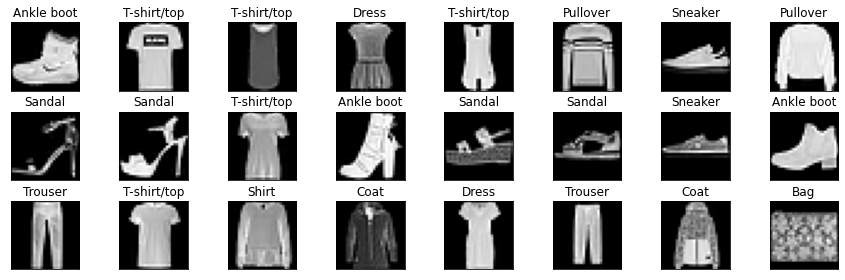

In [5]:
qtf.utils.show_images(train_images, train_labels, classes=params.classes, x_num=3, y_num=8, figsize=(12, 4))

### 类别分布

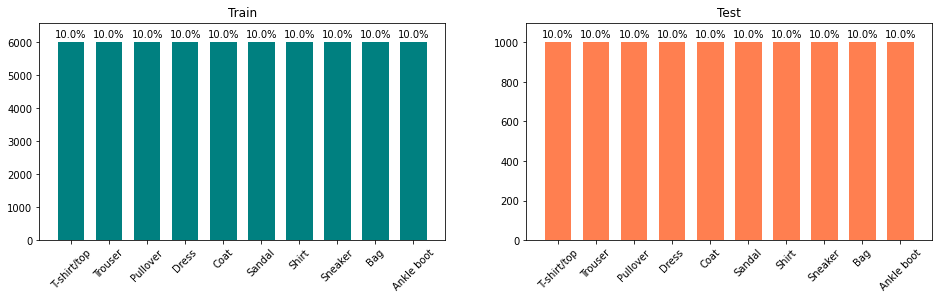

In [6]:
qtf.utils.plot_distribution(train_labels, test_labels, params.classes)



## 准备数据

不同的模型需要准备不同的数据，所以确定一下要构建哪种模型。

### 原始数据


In [7]:
raw_datasets = qtf.classification.Datasets(train_images, train_labels, test_images, test_labels, batch_size=params.batch_size)

In [8]:
sample_images, sample_labels = iter(raw_datasets.train_dataset).next()

In [9]:
raw_datasets.train_dataset.element_spec

(TensorSpec(shape=(32, 28, 28, 1), dtype=tf.float64, name=None),
 TensorSpec(shape=(32,), dtype=tf.uint8, name=None))

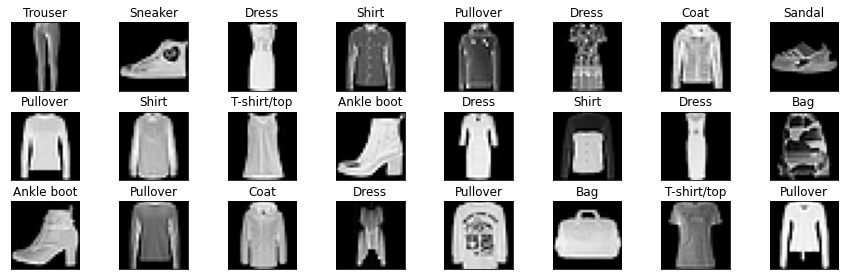

In [10]:
qtf.utils.show_images(sample_images, sample_labels, classes=params.classes, x_num=3, y_num=8, figsize=(12, 4))

### 数据增强

In [11]:
data_generator.fit(train_images)
generator = {'train':qtf.classification.AugmentGenerator('augment', data_generator), 
             'val_test':qtf.classification.DatasetGenerator('val_test')}
augment_datasets = qtf.classification.Datasets(train_images, train_labels, test_images, test_labels, 
                                               generator=generator, batch_size=params.batch_size, 
                                               use_shuffle=False)

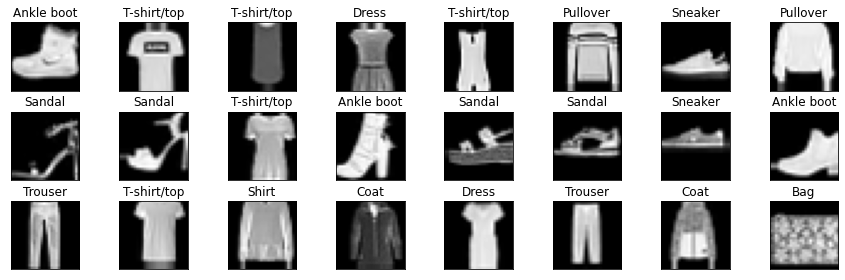

In [12]:
images, labels = iter(augment_datasets.train_dataset).next() 
qtf.utils.show_images(images, labels, classes=params.classes, x_num=3, y_num=8, figsize=(12, 4)) 

看看图片原始的样子

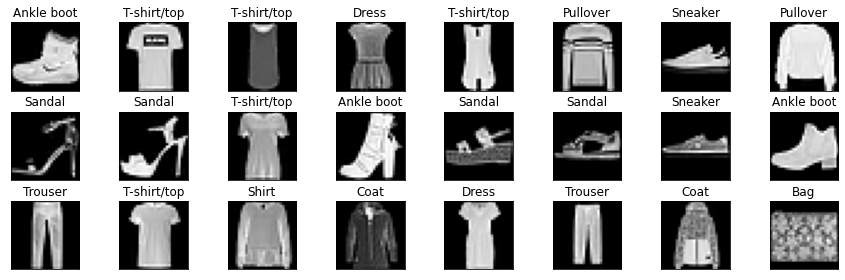

In [13]:
qtf.utils.show_images(train_images, train_labels, classes=params.classes, x_num=3, y_num=8, figsize=(12, 4)) 

设置随机生成训练数据batch

In [14]:
augment_datasets = qtf.classification.Datasets(train_images, train_labels, test_images, test_labels, 
                                               generator=generator, batch_size=params.batch_size, 
                                               use_shuffle=True)

In [15]:
print(f'use_data_augmentation = {params.use_data_augmentation}')
if params.use_data_augmentation:
    datasets = augment_datasets
else:
    datasets = raw_datasets

use_data_augmentation = False


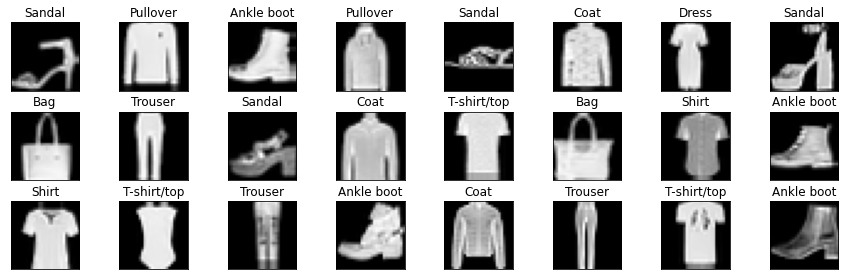

In [16]:
images, labels = iter(augment_datasets.train_dataset).next() 
qtf.utils.show_images(images, labels, classes=params.classes, x_num=3, y_num=8, figsize=(12, 4)) 



##  模型

### MLP

2021-08-10 08:30:47,788: INFO: model_params.mlp1.dropout=0.4
2021-08-10 08:30:47,789: INFO: model_params.mlp1.layer_count=1
2021-08-10 08:30:47,789: INFO: model_params.mlp1.units=128
2021-08-10 08:30:47,850: INFO: learning_rate=0.001
2021-08-10 08:30:47,851: INFO: model_params.mlp1.clip_value=None
2021-08-10 08:30:47,870: INFO: checkpoint_path=/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100/mlp1
2021-08-10 08:30:47,872: INFO: model_params.mlp1.epochs=120
2021-08-10 08:30:47,873: INFO: use ModelCheckpoint(filepath=/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100/mlp1, monitor=val_accuracy)
2021-08-10 08:30:47,874: INFO: use EarlyStopping(monitor=val_accuracy, patience=40)
2021-08-10 08:30:47,874: INFO: use ReduceLROnPlateau(monitor=val_loss, factor=0.31622776601683794, patience=15)
2021-08-10 08:30:47,875: INFO: use LearningRateSchedule

TensorSpec(shape=(32, 28, 28, 1), dtype=tf.float64, name=None)
Model: "mlp1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 128)               100480    
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                1290      
Total params: 101,770
Trainable params: 101,770
Non-trainable params: 0
_________________________________________________________________
Epoch 1/120
1875/1875 [==============================] - 5s

2021-08-10 08:30:53,883: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100/mlp1/assets


Epoch 2/120
1875/1875 [==============================] - 4s 2ms/step - loss: 0.4432 - accuracy: 0.8400 - val_loss: 0.3997 - val_accuracy: 0.8546
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100/mlp1/assets


2021-08-10 08:30:58,323: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100/mlp1/assets


Epoch 3/120
1875/1875 [==============================] - 4s 2ms/step - loss: 0.4129 - accuracy: 0.8504 - val_loss: 0.3955 - val_accuracy: 0.8586
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100/mlp1/assets


2021-08-10 08:31:02,956: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100/mlp1/assets


Epoch 4/120
1875/1875 [==============================] - 4s 2ms/step - loss: 0.3918 - accuracy: 0.8570 - val_loss: 0.3748 - val_accuracy: 0.8631
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100/mlp1/assets


2021-08-10 08:31:07,565: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100/mlp1/assets


Epoch 5/120
1875/1875 [==============================] - 4s 2ms/step - loss: 0.3766 - accuracy: 0.8628 - val_loss: 0.3627 - val_accuracy: 0.8673
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100/mlp1/assets


2021-08-10 08:31:12,151: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100/mlp1/assets


Epoch 6/120
1875/1875 [==============================] - 4s 2ms/step - loss: 0.3663 - accuracy: 0.8661 - val_loss: 0.3660 - val_accuracy: 0.8693
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100/mlp1/assets


2021-08-10 08:31:16,845: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100/mlp1/assets


Epoch 7/120
1875/1875 [==============================] - 4s 2ms/step - loss: 0.3544 - accuracy: 0.8691 - val_loss: 0.3557 - val_accuracy: 0.8679
Epoch 8/120
1875/1875 [==============================] - 4s 2ms/step - loss: 0.3472 - accuracy: 0.8727 - val_loss: 0.3506 - val_accuracy: 0.8733
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100/mlp1/assets


2021-08-10 08:31:25,235: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100/mlp1/assets


Epoch 9/120
1875/1875 [==============================] - 4s 2ms/step - loss: 0.3390 - accuracy: 0.8752 - val_loss: 0.3479 - val_accuracy: 0.8732
Epoch 10/120
1875/1875 [==============================] - 4s 2ms/step - loss: 0.3317 - accuracy: 0.8782 - val_loss: 0.3506 - val_accuracy: 0.8734
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100/mlp1/assets


2021-08-10 08:31:33,706: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100/mlp1/assets


Epoch 11/120
1875/1875 [==============================] - 4s 2ms/step - loss: 0.3290 - accuracy: 0.8769 - val_loss: 0.3537 - val_accuracy: 0.8725
Epoch 12/120
1875/1875 [==============================] - 4s 2ms/step - loss: 0.3234 - accuracy: 0.8798 - val_loss: 0.3468 - val_accuracy: 0.8762
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100/mlp1/assets


2021-08-10 08:31:42,128: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100/mlp1/assets


Epoch 13/120
1875/1875 [==============================] - 4s 2ms/step - loss: 0.3201 - accuracy: 0.8806 - val_loss: 0.3447 - val_accuracy: 0.8769
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100/mlp1/assets


2021-08-10 08:31:46,711: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100/mlp1/assets


Epoch 14/120
1875/1875 [==============================] - 4s 2ms/step - loss: 0.3164 - accuracy: 0.8819 - val_loss: 0.3459 - val_accuracy: 0.8750
Epoch 15/120
1875/1875 [==============================] - 4s 2ms/step - loss: 0.3124 - accuracy: 0.8834 - val_loss: 0.3488 - val_accuracy: 0.8781
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100/mlp1/assets


2021-08-10 08:31:55,134: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100/mlp1/assets


Epoch 16/120
1875/1875 [==============================] - 4s 2ms/step - loss: 0.3077 - accuracy: 0.8850 - val_loss: 0.3423 - val_accuracy: 0.8767
Epoch 17/120
1875/1875 [==============================] - 4s 2ms/step - loss: 0.3038 - accuracy: 0.8865 - val_loss: 0.3394 - val_accuracy: 0.8819
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100/mlp1/assets


2021-08-10 08:32:03,822: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100/mlp1/assets


Epoch 18/120
1875/1875 [==============================] - 4s 2ms/step - loss: 0.2985 - accuracy: 0.8887 - val_loss: 0.3420 - val_accuracy: 0.8821
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100/mlp1/assets


2021-08-10 08:32:08,305: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100/mlp1/assets


Epoch 19/120
1875/1875 [==============================] - 4s 2ms/step - loss: 0.2976 - accuracy: 0.8880 - val_loss: 0.3448 - val_accuracy: 0.8810
Epoch 20/120
1875/1875 [==============================] - 4s 2ms/step - loss: 0.2938 - accuracy: 0.8899 - val_loss: 0.3408 - val_accuracy: 0.8828
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100/mlp1/assets


2021-08-10 08:32:16,520: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100/mlp1/assets


Epoch 21/120
1875/1875 [==============================] - 4s 2ms/step - loss: 0.2910 - accuracy: 0.8903 - val_loss: 0.3406 - val_accuracy: 0.8820
Epoch 22/120
1875/1875 [==============================] - 4s 2ms/step - loss: 0.2902 - accuracy: 0.8916 - val_loss: 0.3486 - val_accuracy: 0.8797
Epoch 23/120
1875/1875 [==============================] - 4s 2ms/step - loss: 0.2851 - accuracy: 0.8909 - val_loss: 0.3434 - val_accuracy: 0.8797
Epoch 24/120
1875/1875 [==============================] - 4s 2ms/step - loss: 0.2833 - accuracy: 0.8935 - val_loss: 0.3371 - val_accuracy: 0.8831
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100/mlp1/assets


2021-08-10 08:32:33,286: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100/mlp1/assets


Epoch 25/120
1875/1875 [==============================] - 4s 2ms/step - loss: 0.2813 - accuracy: 0.8933 - val_loss: 0.3405 - val_accuracy: 0.8821
Epoch 26/120
1875/1875 [==============================] - 4s 2ms/step - loss: 0.2792 - accuracy: 0.8955 - val_loss: 0.3430 - val_accuracy: 0.8826
Epoch 27/120
1875/1875 [==============================] - 4s 2ms/step - loss: 0.2761 - accuracy: 0.8952 - val_loss: 0.3428 - val_accuracy: 0.8816
Epoch 28/120
1875/1875 [==============================] - 4s 2ms/step - loss: 0.2736 - accuracy: 0.8951 - val_loss: 0.3464 - val_accuracy: 0.8826
Epoch 29/120
1875/1875 [==============================] - 4s 2ms/step - loss: 0.2721 - accuracy: 0.8960 - val_loss: 0.3390 - val_accuracy: 0.8859
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100/mlp1/assets


2021-08-10 08:32:53,580: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100/mlp1/assets


Epoch 30/120
1875/1875 [==============================] - 4s 2ms/step - loss: 0.2737 - accuracy: 0.8964 - val_loss: 0.3431 - val_accuracy: 0.8861
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100/mlp1/assets


2021-08-10 08:32:58,310: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100/mlp1/assets


Epoch 31/120
1875/1875 [==============================] - 4s 2ms/step - loss: 0.2677 - accuracy: 0.8975 - val_loss: 0.3469 - val_accuracy: 0.8865
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100/mlp1/assets


2021-08-10 08:33:02,877: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100/mlp1/assets


Epoch 32/120
1875/1875 [==============================] - 4s 2ms/step - loss: 0.2659 - accuracy: 0.8986 - val_loss: 0.3468 - val_accuracy: 0.8818
Epoch 33/120
1875/1875 [==============================] - 4s 2ms/step - loss: 0.2633 - accuracy: 0.8995 - val_loss: 0.3373 - val_accuracy: 0.8868
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100/mlp1/assets


2021-08-10 08:33:11,148: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100/mlp1/assets


Epoch 34/120
1875/1875 [==============================] - 4s 2ms/step - loss: 0.2635 - accuracy: 0.8996 - val_loss: 0.3477 - val_accuracy: 0.8835
Epoch 35/120
1875/1875 [==============================] - 5s 2ms/step - loss: 0.2609 - accuracy: 0.9015 - val_loss: 0.3503 - val_accuracy: 0.8842
Epoch 36/120
1875/1875 [==============================] - 8s 4ms/step - loss: 0.2623 - accuracy: 0.9011 - val_loss: 0.3515 - val_accuracy: 0.8841
Epoch 37/120
1875/1875 [==============================] - 8s 4ms/step - loss: 0.2585 - accuracy: 0.9008 - val_loss: 0.3465 - val_accuracy: 0.8853
Epoch 38/120
1875/1875 [==============================] - 5s 2ms/step - loss: 0.2549 - accuracy: 0.9030 - val_loss: 0.3472 - val_accuracy: 0.8843
Epoch 39/120
1875/1875 [==============================] - 4s 2ms/step - loss: 0.2551 - accuracy: 0.9031 - val_loss: 0.3422 - val_accuracy: 0.8885
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fa

2021-08-10 08:33:44,176: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100/mlp1/assets



Epoch 00039: ReduceLROnPlateau reducing learning rate to 0.00031622778103685084.
Epoch 40/120
Epoch 00040: Still keep learning rate 0.0003162 instead of 0.001
1875/1875 [==============================] - 7s 3ms/step - loss: 0.2277 - accuracy: 0.9142 - val_loss: 0.3450 - val_accuracy: 0.8905
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100/mlp1/assets


2021-08-10 08:33:51,401: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100/mlp1/assets


Epoch 41/120
Epoch 00041: Still keep learning rate 0.0003162 instead of 0.001
1875/1875 [==============================] - 7s 4ms/step - loss: 0.2231 - accuracy: 0.9150 - val_loss: 0.3416 - val_accuracy: 0.8924
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100/mlp1/assets


2021-08-10 08:33:59,156: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100/mlp1/assets


Epoch 42/120
Epoch 00042: Still keep learning rate 0.0003162 instead of 0.001
1875/1875 [==============================] - 4s 2ms/step - loss: 0.2198 - accuracy: 0.9166 - val_loss: 0.3475 - val_accuracy: 0.8922
Epoch 43/120
Epoch 00043: Still keep learning rate 0.0003162 instead of 0.001
1875/1875 [==============================] - 4s 2ms/step - loss: 0.2177 - accuracy: 0.9155 - val_loss: 0.3459 - val_accuracy: 0.8915
Epoch 44/120
Epoch 00044: Still keep learning rate 0.0003162 instead of 0.001
1875/1875 [==============================] - 4s 2ms/step - loss: 0.2153 - accuracy: 0.9166 - val_loss: 0.3485 - val_accuracy: 0.8919
Epoch 45/120
Epoch 00045: Still keep learning rate 0.0003162 instead of 0.001
1875/1875 [==============================] - 4s 2ms/step - loss: 0.2151 - accuracy: 0.9175 - val_loss: 0.3491 - val_accuracy: 0.8934
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p

2021-08-10 08:34:15,807: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100/mlp1/assets


Epoch 46/120
Epoch 00046: Still keep learning rate 0.0003162 instead of 0.001
1875/1875 [==============================] - 4s 2ms/step - loss: 0.2159 - accuracy: 0.9185 - val_loss: 0.3463 - val_accuracy: 0.8937
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100/mlp1/assets


2021-08-10 08:34:20,822: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100/mlp1/assets


Epoch 47/120
Epoch 00047: Still keep learning rate 0.0003162 instead of 0.001
1875/1875 [==============================] - 4s 2ms/step - loss: 0.2122 - accuracy: 0.9192 - val_loss: 0.3434 - val_accuracy: 0.8946
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100/mlp1/assets


2021-08-10 08:34:25,249: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100/mlp1/assets


Epoch 48/120
Epoch 00048: Still keep learning rate 0.0003162 instead of 0.001
1875/1875 [==============================] - 4s 2ms/step - loss: 0.2125 - accuracy: 0.9183 - val_loss: 0.3476 - val_accuracy: 0.8937
Epoch 49/120
Epoch 00049: Still keep learning rate 0.0003162 instead of 0.001
1875/1875 [==============================] - 4s 2ms/step - loss: 0.2111 - accuracy: 0.9202 - val_loss: 0.3527 - val_accuracy: 0.8938
Epoch 50/120
Epoch 00050: Still keep learning rate 0.0003162 instead of 0.001
1875/1875 [==============================] - 4s 2ms/step - loss: 0.2088 - accuracy: 0.9198 - val_loss: 0.3483 - val_accuracy: 0.8910
Epoch 51/120
Epoch 00051: Still keep learning rate 0.0003162 instead of 0.001
1875/1875 [==============================] - 4s 2ms/step - loss: 0.2084 - accuracy: 0.9205 - val_loss: 0.3556 - val_accuracy: 0.8911
Epoch 52/120
Epoch 00052: Still keep learning rate 0.0003162 instead of 0.001
1875/1875 [==============================] - 4s 2ms/step - loss: 0.2090 - accu

2021-08-10 08:35:03,910: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100/mlp1/assets


Epoch 57/120
Epoch 00057: Still keep learning rate 0.0001 instead of 0.001
1875/1875 [==============================] - 4s 2ms/step - loss: 0.1995 - accuracy: 0.9233 - val_loss: 0.3574 - val_accuracy: 0.8932
Epoch 58/120
Epoch 00058: Still keep learning rate 0.0001 instead of 0.001
1875/1875 [==============================] - 4s 2ms/step - loss: 0.1954 - accuracy: 0.9250 - val_loss: 0.3614 - val_accuracy: 0.8947
Epoch 59/120
Epoch 00059: Still keep learning rate 0.0001 instead of 0.001
1875/1875 [==============================] - 4s 2ms/step - loss: 0.1960 - accuracy: 0.9260 - val_loss: 0.3574 - val_accuracy: 0.8950
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100/mlp1/assets


2021-08-10 08:35:16,121: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100/mlp1/assets


Epoch 60/120
Epoch 00060: Still keep learning rate 0.0001 instead of 0.001
1875/1875 [==============================] - 4s 2ms/step - loss: 0.1947 - accuracy: 0.9248 - val_loss: 0.3605 - val_accuracy: 0.8941
Epoch 61/120
1875/1875 [==============================] - 4s 2ms/step - loss: 0.1934 - accuracy: 0.9263 - val_loss: 0.3589 - val_accuracy: 0.8945
Epoch 62/120
1875/1875 [==============================] - 4s 2ms/step - loss: 0.1946 - accuracy: 0.9260 - val_loss: 0.3608 - val_accuracy: 0.8943
Epoch 63/120
1875/1875 [==============================] - 4s 2ms/step - loss: 0.1935 - accuracy: 0.9266 - val_loss: 0.3613 - val_accuracy: 0.8942
Epoch 64/120
1875/1875 [==============================] - 4s 2ms/step - loss: 0.1930 - accuracy: 0.9259 - val_loss: 0.3588 - val_accuracy: 0.8945
Epoch 65/120
1875/1875 [==============================] - 4s 2ms/step - loss: 0.1949 - accuracy: 0.9259 - val_loss: 0.3609 - val_accuracy: 0.8951
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.githu

2021-08-10 08:35:41,215: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100/mlp1/assets


Epoch 66/120
1875/1875 [==============================] - 4s 2ms/step - loss: 0.1938 - accuracy: 0.9251 - val_loss: 0.3606 - val_accuracy: 0.8957
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100/mlp1/assets


2021-08-10 08:35:45,870: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100/mlp1/assets


Epoch 67/120
1875/1875 [==============================] - 4s 2ms/step - loss: 0.1917 - accuracy: 0.9267 - val_loss: 0.3633 - val_accuracy: 0.8946
Epoch 68/120
1875/1875 [==============================] - 4s 2ms/step - loss: 0.1912 - accuracy: 0.9259 - val_loss: 0.3627 - val_accuracy: 0.8934
Epoch 69/120
1875/1875 [==============================] - 4s 2ms/step - loss: 0.1911 - accuracy: 0.9261 - val_loss: 0.3609 - val_accuracy: 0.8939

Epoch 00069: ReduceLROnPlateau reducing learning rate to 3.1622775802825264e-05.
Epoch 70/120
Epoch 00070: Still keep learning rate 3.16e-05 instead of 0.0001
1875/1875 [==============================] - 4s 2ms/step - loss: 0.1890 - accuracy: 0.9287 - val_loss: 0.3630 - val_accuracy: 0.8938
Epoch 71/120
Epoch 00071: Still keep learning rate 3.16e-05 instead of 0.0001
1875/1875 [==============================] - 4s 2ms/step - loss: 0.1885 - accuracy: 0.9280 - val_loss: 0.3637 - val_accuracy: 0.8945
Epoch 72/120
Epoch 00072: Still keep learning rate 3.16e-0

2021-08-10 08:38:22,110: INFO: finish training [elapsed time: 454.23 seconds]


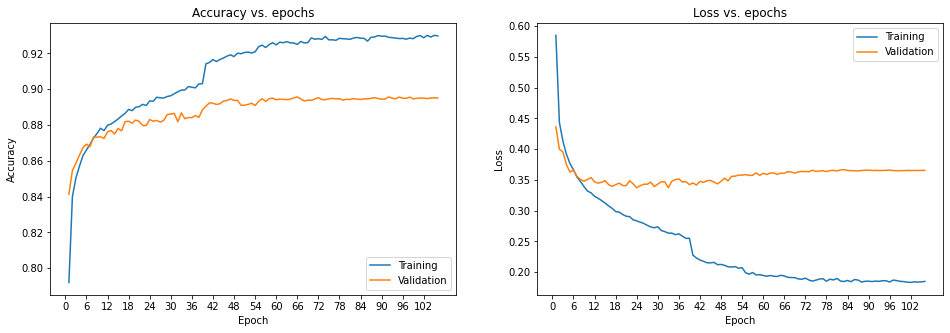

2021-08-10 08:38:22,620: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100/mlp1


load best checkpoint from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100/mlp1
----------------------------------------evaluate----------------------------------------


2021-08-10 08:38:28,686: INFO: test loss:0.3606
2021-08-10 08:38:28,686: INFO: test accuracy:0.8957
2021-08-10 08:38:28,688: INFO: save model results into /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100/results.json
2021-08-10 08:38:28,689: INFO: save json to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100/results.json
2021-08-10 08:38:28,690: INFO: saving generator to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100/default.generator
2021-08-10 08:38:28,691: INFO: save object to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100/default.generator
2021-08-10 08:38:28,691: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashi

----------------------------------------save model results and generator----------------------------------------
----------------------------------------confusion matrix----------------------------------------


2021-08-10 08:38:30,464: INFO: loading generator from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100/default.generator


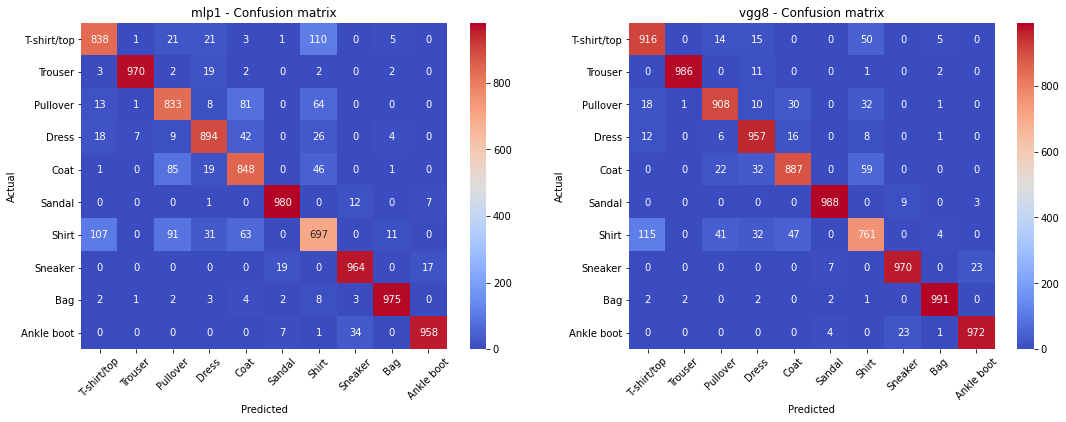

2021-08-10 08:38:34,789: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100/vgg8


----------------------------------------sample analysis----------------------------------------


2021-08-10 08:38:36,437: INFO: loading generator from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100/default.generator
2021-08-10 08:38:36,439: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100/custom1
2021-08-10 08:38:37,434: INFO: loading generator from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100/default.generator
2021-08-10 08:38:37,436: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100/lenet1
2021-08-10 08:38:38,274: INFO: loading generator from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100/default.generator
2021-08-10 08:38:38,276: INFO: loading model

2021-08-10 08:38:44,729: WARNING: 5 out of the last 631 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7f3ae042b9d8> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


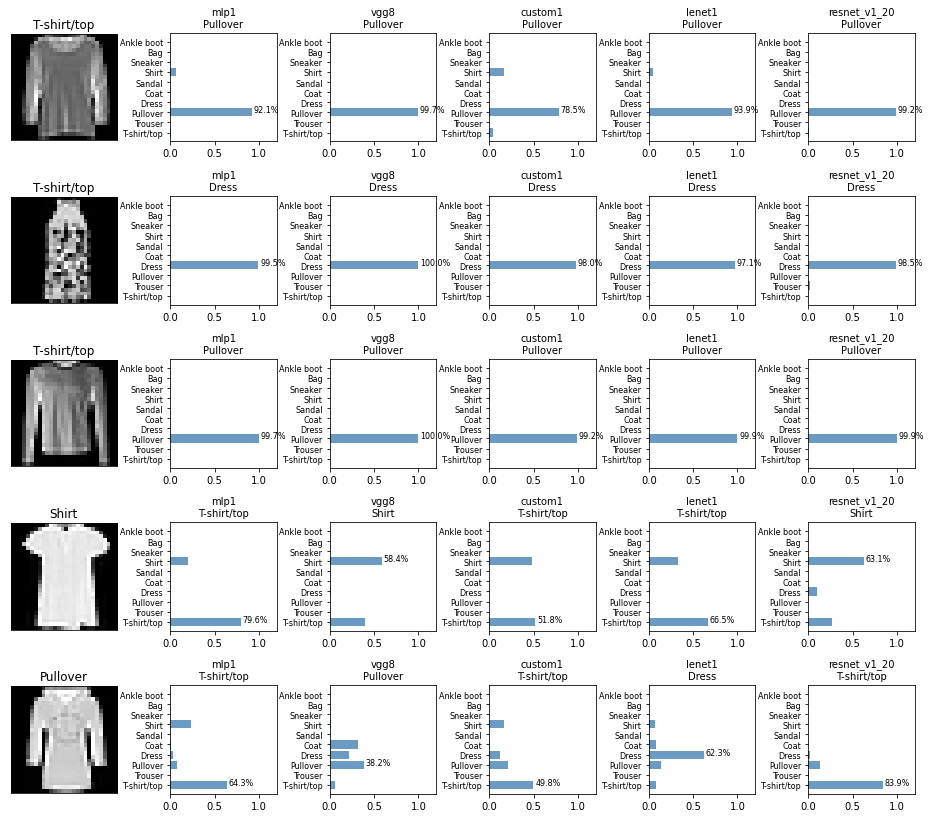

----------------------------------------models----------------------------------------


,model_name,weight_number,train_time,train_loss,test_loss,train_accuracy,test_accuracy,train_auc,test_auc
1,vgg8,1442378,439.9,0.1022,0.1981,0.9616,0.9336,0.9988,0.9967
2,custom1,73162,208.8,0.1880,0.2415,0.9304,0.9108,0.9964,0.9947
3,lenet1,61750,145.3,0.1926,0.2595,0.9266,0.9042,0.9963,0.9939
4,resnet_v1_20,272778,681.8,0.3390,0.5146,0.9378,0.9009,0.9977,0.9930
5,mlp1,101770,453.7,0.1428,0.3606,0.9467,0.8957,0.9977,0.9913


In [17]:
helper = qtf.classification.Classification(params, datasets=datasets, model_results=model_results, task_type='image')
model = qtf.classification.image_models.mlp1(helper, name='mlp1')
model.summary()
history = helper.train(model)
helper.model_summary(model, history, show_sample_analysis=True) 




从上面的错误来看，模型对一些细节的判断不是很准。下面来尝试一下LeNet。

### LeNet

![image-20201019113632136](images/image-20201019113632136.png)

LeNet诞生于1994年，是Yann LeCun等人提出的，是最早的卷积神经网络之一。在LeNet中，输入层是32×32的图片，而MNIST是28×28的图片，为了保持模型的结构不变，在第一个Conv2D设置参数padding=’same’。首先创建模型，并训练。

In [ ]:
helper = qtf.classification.Classification(params, datasets=datasets, model_results=model_results, task_type='image')
model = qtf.classification.image_models.lenet1(helper, name='lenet1')
model.summary()
history = helper.train(model)
helper.model_summary(model, history, show_sample_analysis=True) 

2021-08-10 08:38:49,235: INFO: model_params.lenet1.dropout=0.2
2021-08-10 08:38:49,317: INFO: learning_rate=0.001
2021-08-10 08:38:49,317: INFO: model_params.lenet1.clip_value=None
2021-08-10 08:38:49,323: INFO: checkpoint_path=/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100/lenet1
2021-08-10 08:38:49,328: INFO: model_params.lenet1.epochs=120
2021-08-10 08:38:49,328: INFO: use ModelCheckpoint(filepath=/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100/lenet1, monitor=val_accuracy)
2021-08-10 08:38:49,329: INFO: use EarlyStopping(monitor=val_accuracy, patience=40)
2021-08-10 08:38:49,329: INFO: use ReduceLROnPlateau(monitor=val_loss, factor=0.31622776601683794, patience=15)
2021-08-10 08:38:49,330: INFO: use LearningRateScheduler()
2021-08-10 08:38:49,331: INFO: steps_per_epoch=1875
2021-08-10 08:38:49,331: INFO: start training
2021-08-10

TensorSpec(shape=(32, 28, 28, 1), dtype=tf.float64, name=None)
Model: "lenet1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 28, 28, 6)         156       
_________________________________________________________________
batch_normalization (BatchNo (None, 28, 28, 6)         24        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 6)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 14, 14, 6)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 10, 10, 16)        2416      
_______________________________________________________________

2021-08-10 08:39:00,726: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/fashion_mnist/fashion_mnist_0721_p100/lenet1/assets


Epoch 2/120
 655/1875 [=========>....................] - ETA: 5s - loss: 0.4285 - accuracy: 0.8441

从上面的图中，可以看到，Lenet的参数只有mlp的60%，但其的准确率比mlp提升了差不多1%。上面最后一张图中，有三列，第一列是数字图片，它们是mlp中分错的数字，第二列是mlp中的分类，第三列是lenet中的分类，可以看到lenet的确学到了一些mlp中没有的模式。下面再来看看哪些数字在lenet也分错了。

### Custom 1

下面自己定义一个模型，这个模型和lenet的主要区别是，增加了卷积的深度

In [ ]:
helper = qtf.classification.Classification(params, datasets=datasets, model_results=model_results, task_type='image')
model = qtf.classification.image_models.custom1(helper, name='custom1')
model.summary()
history = helper.train(model)
helper.model_summary(model, history, show_sample_analysis=True) 

### VGG

In [ ]:
helper = qtf.classification.Classification(params, datasets=datasets, model_results=model_results, task_type='image')
model = qtf.classification.image_models.vgg1(helper, name='vgg8', dense_layer_count=1, block_count=3,)
model.summary()
history = helper.train(model)
helper.model_summary(model, history, show_sample_analysis=True) 

### Resnet

参考https://github.com/PacktPublishing/Advanced-Deep-Learning-with-Keras/blob/master/chapter2-deep-networks/resnet-cifar10-2.2.1.py

In [ ]:
helper = qtf.classification.Classification(params, datasets=datasets, model_results=model_results, task_type='image')
model = qtf.classification.image_models.resnet_v1(helper, name='resnet_v1', depth=20)
model.summary()
history = helper.train(model)
helper.model_summary(model, history, show_sample_analysis=True) 

## 评估

### 最佳模型

In [ ]:
data_model_results = qtf.classification.DataModelResults(params.data_path) 
data_model_results.show(10)

In [ ]:

predictors = qtf.classification.Predictor.get_top_n_predictors(5, data_model_results)

best_predictor = predictors[0]
best_predictor.model.compile(optimizer=optimizers.Adam(learning_rate=params.learning_rate),
                        loss=losses.SparseCategoricalCrossentropy(from_logits=True),
                        metrics=['accuracy', 'mae'])

qtf.utils.plot_model_structure(best_predictor.model)

In [ ]:
qtf.utils.plot_sample_image_analysis(predictors, test_images, test_labels,
                                    sample_count=5, show_error_sample=False) 

In [ ]:
qtf.utils.plot_sample_image_analysis(predictors, test_images, test_labels,
                                    sample_count=5, show_error_sample=True) 

### 评估

In [ ]:
results = best_predictor.evaluate(test_images, test_labels)
print(results)

predictions = best_predictor.predict(test_images)
print(predictions.shape)

In [ ]:
top1_predictions = best_predictor.predict_top_k(test_images, test_labels, top_k=1)
top1_scores = qtf.utils.score(test_labels, top1_predictions, params.classes)
display(top1_scores)
print('-'*100)
print(classification_report(test_labels, top1_predictions, digits=4, target_names=params.classes))

In [ ]:
qtf.utils.plot_confusion_matrix(test_labels, top1_predictions, params.classes)


## 参考

- [Text classification Guide](https://developers.google.com/machine-learning/guides/text-classification)

In [ ]:
type(helper.datasets.train_dataset)